In [22]:
import nlp
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset as TorchDataset, DataLoader

from models.seq2seq_generator import Seq2Seq, Encoder, Decoder
from models.lstm_generator import LSTMGenerator
from models.cnn_discriminator import CNNDiscriminator
from models.rollout import ROLLOUT

sns.set_style('whitegrid')

### 1. load data

In [2]:
%%time
train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")

CPU times: user 202 ms, sys: 3.38 ms, total: 205 ms
Wall time: 3.85 s


In [2]:
%%time
train_articles = [item['article'] for item in train_dataset]
train_highlights = [item['highlights'] for item in train_dataset]
val_articles = [item['article'] for item in val_dataset]
val_highlights = [item['highlights'] for item in val_dataset]

NameError: name 'train_dataset' is not defined

In [3]:
def process_str(s):
    s = s.lower()
    s = re.sub("[^0-9a-zA-Z ]", " ", s)
    return s

news = pd.read_csv('data/news_summary.csv')
news.headlines = [process_str(s) for s in news.headlines]
news.text = [process_str(s) for s in news.text]
X_train, X_test = train_test_split(news, test_size=0.3,
                                   random_state=42)

train_articles = X_train.text.values
train_highlights = X_train.headlines.values
val_articles = X_test.text.values
val_highlights = X_test.headlines.values

In [4]:
'''
%%time
with open('data/news_texts.txt', 'a') as f:
    for article in tqdm(train_articles):
        f.write(article + '\n')
    for highlight in tqdm(train_highlights):
        f.write(highlight + '\n')
    for article in tqdm(val_articles):
        f.write(article + '\n')
    for highlight in tqdm(val_highlights):
        f.write(highlight + '\n')
'''

"\n%%time\nwith open('data/news_texts.txt', 'a') as f:\n    for article in tqdm(train_articles):\n        f.write(article + '\n')\n    for highlight in tqdm(train_highlights):\n        f.write(highlight + '\n')\n    for article in tqdm(val_articles):\n        f.write(article + '\n')\n    for highlight in tqdm(val_highlights):\n        f.write(highlight + '\n')\n"

In [5]:
'''
%%time
spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                               model_prefix='news10k',
                               vocab_size=10000)
'''

"\n%%time\nspm.SentencePieceTrainer.train(input='data/news_texts.txt',\n                               model_prefix='news10k',\n                               vocab_size=10000)\n"

### 2. dataset and dataloaders

In [6]:
sp = spm.SentencePieceProcessor(model_file='news10k.model')

In [7]:
class Dataset(TorchDataset):
    def __init__(self, articles, highlights):
        self.articles = articles
        self.highlights = highlights

    def __getitem__(self, index):
        article = self.articles[index]
        highlight = self.highlights[index]
        
        return (torch.tensor([1] + sp.encode(article) + [2], dtype=torch.long),
                torch.tensor([1] + sp.encode(highlight) + [2], dtype=torch.long))

    def __len__(self):
        return len(self.articles)

In [8]:
def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = length - vec.shape[dim]
    return torch.cat([vec, torch.zeros(pad_size, dtype=torch.long) + pad_symbol],
                     dim=dim)

class Padder:
    def __init__(self, dim=0, pad_symbol=0):
        self.dim = dim
        self.pad_symbol = pad_symbol
        
    def __call__(self, batch):
        max_article_len = max(map(lambda x: x[0].shape[self.dim], batch))
        max_highlight_len = max(map(lambda x: x[1].shape[self.dim], batch))
        batch = map(lambda x: (pad_tensor(x[0], max_article_len, self.dim, self.pad_symbol), 
                               pad_tensor(x[1], max_highlight_len, self.dim, self.pad_symbol)),
                    batch)
        batch = list(batch)
        xs = torch.stack(list(map(lambda x: x[0], batch)))
        ys = torch.stack(list(map(lambda x: x[1], batch)))
        return xs.permute(1, 0), ys.permute(1, 0)

In [9]:
train_dataset = Dataset(train_articles, train_highlights)
val_dataset = Dataset(val_articles, val_highlights)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [10]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([94, 128])
torch.Size([20, 128])


### 3. model architecture

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [12]:
vocab_size = 10000

In [13]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)

In [47]:
emb_dim = 128
hidden_dim = 128
vocab_size = 10000
max_seq_len = 3000
padding_idx = 0
D = CNNDiscriminator(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     filter_sizes=[2, 3],
                     num_filters=[2, 2],
                     padding_idx=padding_idx).to(device)

### 4. generator pretraining

In [15]:
len(train_dataloader)

539

In [16]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 5e-4
opt = torch.optim.Adam(G.parameters(), lr=lr)
n_epochs = 50

epoch_losses = []
val_losses = []

for epoch_idx in range(n_epochs):
    G.train()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        opt.zero_grad()
        out = G(article, highlight, teacher_forcing_ratio=0.5)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1)
    
    epoch_losses.append(total_loss / len(train_dataset))
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')

539it [01:22,  6.56it/s]
2it [00:00, 16.81it/s]

epoch 0 train loss: 5.440908861430264


231it [00:13, 17.38it/s]
1it [00:00,  6.59it/s]

epoch 0 val loss: 5.384867251240372


539it [01:22,  6.53it/s]
2it [00:00, 16.69it/s]

epoch 1 train loss: 5.26267992998111


231it [00:13, 17.38it/s]
1it [00:00,  6.47it/s]

epoch 1 val loss: 5.323798906487754


539it [01:22,  6.55it/s]
2it [00:00, 16.14it/s]

epoch 2 train loss: 5.018614977708954


231it [00:13, 17.35it/s]
1it [00:00,  6.83it/s]

epoch 2 val loss: 5.138498446833235


539it [01:21,  6.59it/s]
2it [00:00, 17.19it/s]

epoch 3 train loss: 4.768024863647113


231it [00:13, 17.36it/s]
1it [00:00,  5.93it/s]

epoch 3 val loss: 4.9688074607916315


539it [01:21,  6.59it/s]
2it [00:00, 17.16it/s]

epoch 4 train loss: 4.5514755148159365


231it [00:13, 17.36it/s]
1it [00:00,  6.21it/s]

epoch 4 val loss: 4.838187696891669


539it [01:21,  6.59it/s]
2it [00:00, 17.08it/s]

epoch 5 train loss: 4.386911828454225


231it [00:13, 17.29it/s]
1it [00:00,  6.66it/s]

epoch 5 val loss: 4.740804786196908


539it [01:21,  6.61it/s]
2it [00:00, 17.13it/s]

epoch 6 train loss: 4.212606737581833


231it [00:13, 17.36it/s]
1it [00:00,  6.23it/s]

epoch 6 val loss: 4.671409317852783


539it [01:21,  6.60it/s]
2it [00:00, 17.12it/s]

epoch 7 train loss: 4.085087910955653


231it [00:13, 17.36it/s]
1it [00:00,  6.77it/s]

epoch 7 val loss: 4.62852204263923


539it [01:22,  6.57it/s]
2it [00:00, 17.27it/s]

epoch 8 train loss: 3.944124033607534


231it [00:13, 17.38it/s]
1it [00:00,  6.19it/s]

epoch 8 val loss: 4.566516488787483


539it [01:21,  6.58it/s]
2it [00:00, 16.82it/s]

epoch 9 train loss: 3.8422238241850843


231it [00:13, 17.36it/s]
1it [00:00,  6.12it/s]

epoch 9 val loss: 4.550974634708798


539it [01:21,  6.59it/s]
2it [00:00, 17.20it/s]

epoch 10 train loss: 3.7350746390642326


231it [00:13, 17.38it/s]
1it [00:00,  6.14it/s]

epoch 10 val loss: 4.517066974497105


539it [01:21,  6.58it/s]
2it [00:00, 16.27it/s]

epoch 11 train loss: 3.630380888233063


231it [00:13, 17.40it/s]
1it [00:00,  6.24it/s]

epoch 11 val loss: 4.468263379434216


539it [01:22,  6.56it/s]
2it [00:00, 17.18it/s]

epoch 12 train loss: 3.5354603795501274


231it [00:13, 17.38it/s]
1it [00:00,  6.61it/s]

epoch 12 val loss: 4.512703183374004


539it [01:22,  6.56it/s]
2it [00:00, 16.74it/s]

epoch 13 train loss: 3.4499093074381837


231it [00:13, 17.35it/s]
1it [00:00,  6.82it/s]

epoch 13 val loss: 4.47516784460894


539it [01:22,  6.51it/s]
2it [00:00, 16.25it/s]

epoch 14 train loss: 3.3785938642339284


231it [00:13, 17.33it/s]
1it [00:00,  6.62it/s]

epoch 14 val loss: 4.461277538245417


539it [01:21,  6.58it/s]
2it [00:00, 17.15it/s]

epoch 15 train loss: 3.3071104250545424


231it [00:13, 17.39it/s]
1it [00:00,  6.58it/s]

epoch 15 val loss: 4.4417945058489305


539it [01:22,  6.56it/s]
2it [00:00, 17.27it/s]

epoch 16 train loss: 3.2405617860136133


231it [00:13, 17.39it/s]
1it [00:00,  6.32it/s]

epoch 16 val loss: 4.448955377642893


539it [01:22,  6.57it/s]
2it [00:00, 16.55it/s]

epoch 17 train loss: 3.1598917260471815


231it [00:13, 17.30it/s]
1it [00:00,  6.91it/s]

epoch 17 val loss: 4.494444876262148


539it [01:22,  6.57it/s]
2it [00:00, 17.17it/s]

epoch 18 train loss: 3.0961263607949467


231it [00:13, 17.35it/s]
1it [00:00,  6.19it/s]

epoch 18 val loss: 4.517509302962606


539it [01:21,  6.58it/s]
2it [00:00, 16.68it/s]

epoch 19 train loss: 3.036503652015076


231it [00:13, 17.33it/s]
1it [00:00,  6.62it/s]

epoch 19 val loss: 4.508602182634405


539it [01:22,  6.55it/s]
2it [00:00, 17.15it/s]

epoch 20 train loss: 2.9891946099707196


231it [00:13, 17.33it/s]
1it [00:00,  6.32it/s]

epoch 20 val loss: 4.529019005442937


539it [01:21,  6.58it/s]
2it [00:00, 17.16it/s]

epoch 21 train loss: 2.9346756938234853


231it [00:13, 17.38it/s]
1it [00:00,  6.78it/s]

epoch 21 val loss: 4.539132518903346


539it [01:22,  6.57it/s]
2it [00:00, 17.13it/s]

epoch 22 train loss: 2.880403869700349


231it [00:13, 17.28it/s]
1it [00:00,  6.66it/s]

epoch 22 val loss: 4.574673397811358


539it [01:21,  6.58it/s]
2it [00:00, 17.12it/s]

epoch 23 train loss: 2.8258827202861454


231it [00:13, 17.37it/s]
1it [00:00,  6.54it/s]

epoch 23 val loss: 4.574736796898198


539it [01:22,  6.56it/s]
2it [00:00, 17.09it/s]

epoch 24 train loss: 2.798707004093958


231it [00:13, 17.28it/s]
1it [00:00,  6.50it/s]

epoch 24 val loss: 4.592347203956331


539it [01:21,  6.59it/s]
2it [00:00, 17.17it/s]

epoch 25 train loss: 2.743925481048195


231it [00:13, 17.37it/s]
1it [00:00,  6.66it/s]

epoch 25 val loss: 4.566373972722999


539it [01:22,  6.57it/s]
2it [00:00, 17.23it/s]

epoch 26 train loss: 2.7068223597176813


231it [00:13, 17.36it/s]
1it [00:00,  6.33it/s]

epoch 26 val loss: 4.542677485843099


539it [01:22,  6.55it/s]
2it [00:00, 16.82it/s]

epoch 27 train loss: 2.6685343229327607


231it [00:13, 17.33it/s]
1it [00:00,  6.63it/s]

epoch 27 val loss: 4.547637203562603


539it [01:21,  6.58it/s]
2it [00:00, 17.07it/s]

epoch 28 train loss: 2.6356402930343883


231it [00:13, 17.38it/s]
1it [00:00,  6.49it/s]

epoch 28 val loss: 4.602098024294049


539it [01:22,  6.55it/s]
2it [00:00, 16.62it/s]

epoch 29 train loss: 2.5935375075133975


231it [00:13, 17.32it/s]
1it [00:00,  6.47it/s]

epoch 29 val loss: 4.624524486391595


539it [01:22,  6.57it/s]
2it [00:00, 17.24it/s]

epoch 30 train loss: 2.5632472376894038


231it [00:13, 17.37it/s]
1it [00:00,  6.72it/s]

epoch 30 val loss: 4.646152847686485


539it [01:22,  6.55it/s]
2it [00:00, 16.77it/s]

epoch 31 train loss: 2.535000088135955


231it [00:13, 17.37it/s]
1it [00:00,  6.87it/s]

epoch 31 val loss: 4.608136794442815


539it [01:22,  6.57it/s]
2it [00:00, 17.17it/s]

epoch 32 train loss: 2.4963408571640926


231it [00:13, 17.38it/s]
1it [00:00,  6.93it/s]

epoch 32 val loss: 4.625243181588062


539it [01:22,  6.57it/s]
2it [00:00, 17.11it/s]

epoch 33 train loss: 2.47109452091443


231it [00:13, 17.36it/s]
1it [00:00,  6.69it/s]

epoch 33 val loss: 4.619426851265153


539it [01:22,  6.57it/s]
2it [00:00, 17.23it/s]

epoch 34 train loss: 2.420840654029802


231it [00:13, 17.38it/s]
1it [00:00,  6.01it/s]

epoch 34 val loss: 4.74321709389585


539it [01:21,  6.58it/s]
2it [00:00, 17.18it/s]

epoch 35 train loss: 2.390584981673409


231it [00:13, 17.35it/s]
1it [00:00,  6.11it/s]

epoch 35 val loss: 4.690463998793328


539it [01:22,  6.54it/s]
2it [00:00, 17.19it/s]

epoch 36 train loss: 2.3703090731932863


231it [00:13, 17.34it/s]
1it [00:00,  6.53it/s]

epoch 36 val loss: 4.7321368253294445


539it [01:22,  6.56it/s]
2it [00:00, 17.12it/s]

epoch 37 train loss: 2.336400428971624


231it [00:13, 17.32it/s]
1it [00:00,  6.72it/s]

epoch 37 val loss: 4.687061225062426


539it [01:21,  6.58it/s]
2it [00:00, 16.55it/s]

epoch 38 train loss: 2.3159740475481256


231it [00:13, 17.35it/s]
1it [00:00,  6.76it/s]

epoch 38 val loss: 4.739744891828325


539it [01:21,  6.59it/s]
2it [00:00, 16.72it/s]

epoch 39 train loss: 2.278995563015428


231it [00:13, 17.34it/s]
1it [00:00,  5.93it/s]

epoch 39 val loss: 4.776034896562168


539it [01:21,  6.59it/s]
2it [00:00, 17.19it/s]

epoch 40 train loss: 2.268955793502577


231it [00:13, 17.36it/s]
1it [00:00,  6.72it/s]

epoch 40 val loss: 4.779762342852357


539it [01:22,  6.57it/s]
2it [00:00, 16.95it/s]

epoch 41 train loss: 2.2328799907754107


231it [00:13, 17.33it/s]
1it [00:00,  6.70it/s]

epoch 41 val loss: 4.769681590807026


539it [01:22,  6.55it/s]
2it [00:00, 17.25it/s]

epoch 42 train loss: 2.204797968081481


231it [00:13, 17.37it/s]
1it [00:00,  6.18it/s]

epoch 42 val loss: 4.83472436558469


539it [01:21,  6.58it/s]
2it [00:00, 17.15it/s]

epoch 43 train loss: 2.1796086106635415


231it [00:13, 17.36it/s]
1it [00:00,  6.65it/s]

epoch 43 val loss: 4.821882885010648


539it [01:22,  6.57it/s]
2it [00:00, 17.17it/s]

epoch 44 train loss: 2.1671095303715173


231it [00:13, 17.31it/s]
1it [00:00,  6.63it/s]

epoch 44 val loss: 4.81643808973881


539it [01:21,  6.58it/s]
2it [00:00, 17.18it/s]

epoch 45 train loss: 2.157314030049016


231it [00:13, 17.34it/s]
1it [00:00,  6.48it/s]

epoch 45 val loss: 4.898936760134419


539it [01:22,  6.55it/s]
2it [00:00, 17.20it/s]

epoch 46 train loss: 2.1207167443463475


231it [00:13, 17.34it/s]
1it [00:00,  6.68it/s]

epoch 46 val loss: 4.872603138022693


539it [01:21,  6.58it/s]
2it [00:00, 17.20it/s]

epoch 47 train loss: 2.1007281482600444


231it [00:13, 17.34it/s]
1it [00:00,  7.12it/s]

epoch 47 val loss: 4.826751241095687


539it [01:21,  6.58it/s]
2it [00:00, 16.67it/s]

epoch 48 train loss: 2.0762074986089813


231it [00:13, 17.36it/s]
1it [00:00,  6.15it/s]

epoch 48 val loss: 4.897870053056496


539it [01:21,  6.59it/s]
2it [00:00, 17.12it/s]

epoch 49 train loss: 2.0622479236603612


231it [00:13, 17.31it/s]

epoch 49 val loss: 4.867047413251316


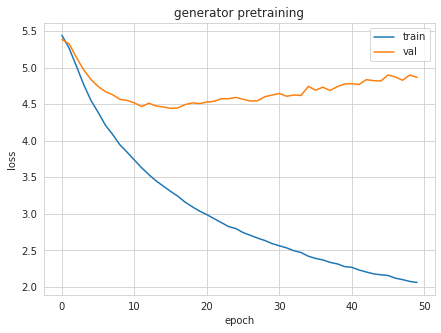

In [29]:
plt.figure(figsize=(7, 5))
plt.title('generator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [43]:
for batch in train_dataloader:
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    break

In [44]:
out = G(article, highlight, teacher_forcing_ratio=1.)

### 5. discriminator pretraining

In [49]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
opt = torch.optim.Adam(D.parameters(), lr=lr)
n_epochs = 10

epoch_losses = []
val_losses = []

for epoch_idx in range(n_epochs):
    D.train()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        opt.zero_grad()
        out = D(batch)
        loss = criterion(out, targets)
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1) * 2
    
    epoch_losses.append(total_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    D.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        out = D(batch)
        loss = criterion(out, targets)
        total_loss += loss.data.item() * article.size(1) * 2

    val_losses.append(total_loss / len(val_dataset) / 2)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')

539it [00:32, 16.40it/s]
2it [00:00, 16.92it/s]

epoch 0 train loss: 0.041747224099017925


231it [00:13, 17.07it/s]
2it [00:00, 16.25it/s]

epoch 0 val loss: 0.0008103516810878357


539it [00:32, 16.45it/s]
2it [00:00, 16.86it/s]

epoch 1 train loss: 0.015736963659564535


231it [00:13, 17.11it/s]
2it [00:00, 16.51it/s]

epoch 1 val loss: 0.000297432459294802


539it [00:32, 16.37it/s]
2it [00:00, 16.96it/s]

epoch 2 train loss: 0.014128395729047477


231it [00:13, 17.10it/s]
2it [00:00, 15.60it/s]

epoch 2 val loss: 0.0003377491610975173


539it [00:32, 16.35it/s]
2it [00:00, 16.86it/s]

epoch 3 train loss: 0.01552150912667245


231it [00:13, 17.08it/s]
2it [00:00, 16.65it/s]

epoch 3 val loss: 0.002164781900195763


539it [00:33, 16.30it/s]
2it [00:00, 16.09it/s]

epoch 4 train loss: 0.014272258875210246


231it [00:13, 17.15it/s]
2it [00:00, 16.15it/s]

epoch 4 val loss: 0.00042203229321568163


539it [00:32, 16.42it/s]
2it [00:00, 16.89it/s]

epoch 5 train loss: 0.014938424805662747


231it [00:13, 16.94it/s]
2it [00:00, 16.00it/s]

epoch 5 val loss: 0.00012634182956043933


539it [00:33, 16.31it/s]
2it [00:00, 16.80it/s]

epoch 6 train loss: 0.01445199973608392


231it [00:13, 16.99it/s]
2it [00:00, 17.52it/s]

epoch 6 val loss: 0.005688416505232643


539it [00:33, 16.21it/s]
2it [00:00, 16.69it/s]

epoch 7 train loss: 0.01599743409154225


231it [00:13, 16.96it/s]
2it [00:00, 16.54it/s]

epoch 7 val loss: 0.0006906930100024358


539it [00:33, 16.17it/s]
2it [00:00, 16.51it/s]

epoch 8 train loss: 0.014462424600363706


231it [00:13, 17.02it/s]
2it [00:00, 16.04it/s]

epoch 8 val loss: 0.0009012373861045065


539it [00:33, 16.28it/s]
2it [00:00, 16.65it/s]

epoch 9 train loss: 0.014576041467612745


231it [00:13, 16.98it/s]

epoch 9 val loss: 0.0012922477657548613


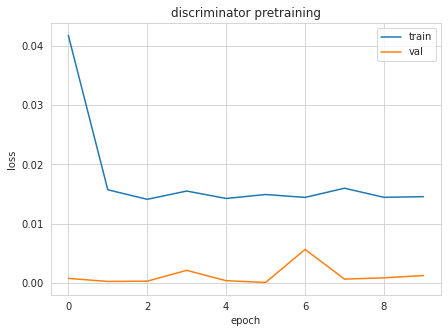

In [51]:
plt.figure(figsize=(7, 5))
plt.title('discriminator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 6. adversarial training

In [26]:
n_epochs = 10

In [63]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-10)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

G_losses = []
D_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = criterion(out, targets)
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(0) * 2
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        generated_highlight = G(article, highlight.permute(1, 0), teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        fake_targets = torch.tensor([1]*generated_highlight.size(0)).to(device)
        discriminator_output_on_generated_data = D(generated_highlight)
        loss = criterion(discriminator_output_on_generated_data, fake_targets)
        loss.backward()
        generator_optimizer.step()
        total_G_loss += loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')

539it [01:01,  8.83it/s]
1it [00:00,  8.96it/s]

epoch 0 G loss: 152.94498942482625
epoch 0 D loss: 0.0


539it [01:01,  8.83it/s]
1it [00:00,  8.89it/s]

epoch 1 G loss: 152.94277863718492
epoch 1 D loss: 8.65340319725275e-13


539it [01:01,  8.80it/s]
1it [00:00,  8.67it/s]

epoch 2 G loss: 152.98896014028585
epoch 2 D loss: 2.596016492494574e-11


539it [01:01,  8.80it/s]
1it [00:00,  9.25it/s]

epoch 3 G loss: 152.914115230547
epoch 3 D loss: 5.955784202968787e-08


539it [01:01,  8.80it/s]
1it [00:00,  8.85it/s]

epoch 4 G loss: 152.91048298657424
epoch 4 D loss: 8.65340319725275e-13


539it [01:01,  8.77it/s]
1it [00:00,  8.85it/s]

epoch 5 G loss: 153.00113893657334
epoch 5 D loss: 0.0


539it [01:01,  8.78it/s]
1it [00:00,  8.26it/s]

epoch 6 G loss: 152.92684895762446
epoch 6 D loss: 5.955611134930631e-08


539it [01:01,  8.79it/s]
1it [00:00,  9.25it/s]

epoch 7 G loss: 152.95342940663903
epoch 7 D loss: 0.0


539it [01:01,  8.80it/s]
1it [00:00,  8.92it/s]

epoch 8 G loss: 152.9694365710747
epoch 8 D loss: 0.0


539it [01:01,  8.80it/s]

epoch 9 G loss: 152.95702786506538
epoch 9 D loss: 1.1249417348092258e-11
